In [ ]:
# Metabolic Profile of Human Pituitary Tumours. A data driven approach to classifying human pituitary tumours
# Sample data involved the 1D 1H-NMR spectra for n-samples of Human Pituitary Tumours. n = 134


#Packages for the analysis:

from scipy.signal import find_peaks
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import scipy.signal as ssig
import scipy.signal as sig # import the complete module of scipy.signal with alias sig
import scipy.stats as ss
from scipy.stats import zscore
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
from metabolabpy.nmr import nmrDataSet
from scipy.stats import ranksums
from scipy.spatial.distance import euclidean 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
import seaborn as sbn
import sklearn.metrics as skm
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
nd = nmrDataSet.NmrDataSet()
dc = nd.load('karavitaki_allSpectra7_tsaScaling.mlpy')

In [ ]:
nd.nmrdat[0][1].title

In [ ]:
# Extraction of nmr spectra from the nmr spectroscopy data signal for the n-sample = 134

In [33]:
rol = [] # initializes an empty list
nspc = len(nd.nmrdat[0])# Calculate the number of Spectra of in The nd.nmrdat[0]
for i in range(134):# Start a loop that iterates over the of value from 0 to nspc
    rol.append(nd.nmrdat[0][i].spc[0].real)#Accesses the 'i'th spectrum and retrieves the real part of the first data point and append to the rol list
        
rol = np.array(rol)
#rol # the array values of all the 150 samples

class:  ndarray
shape:  (131072,)
strides:  (16,)
itemsize:  8
aligned:  True
contiguous:  False
fortran:  False
data pointer: 0x1be0fcfe060
byteorder:  little
byteswap:  False
type: float64


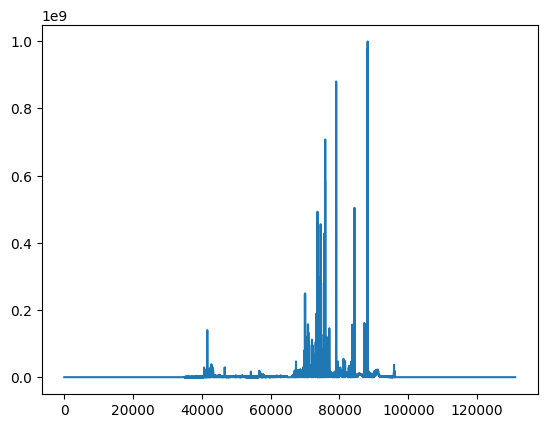

In [59]:
# Random assessment of individual pituitary Sample Spectrum. n-Sample = 13(pituitary tumour number 13) 

nspc = len(nd.nmrdat[0])# Calculates the number of Spectra in the nd.nmrdat[0] object and assigns it 
for samp in range(nspc): # Starts a loop that iterates over the range of values from 0 to nspc -1'. 
    samp = nd.nmrdat[0][13].spc[0].real # assigned the real part of the first data point of the spectrum at index 13 
np.info(samp) # Call the np.info() function to display information about the variable Samp
plt.plot(samp)# Plot the vaues in 'samp'

C:\Users\bosmi\AppData\Local\Temp\ipykernel_219768\1723261217.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  rold[i] = (nd.nmrdat[0][i].spc[0])# assigns the data from the nd.nmrdat[0][i].spc[0] array to the i-th row of the rold array - it populate the rold array with the spectra data


 ...]

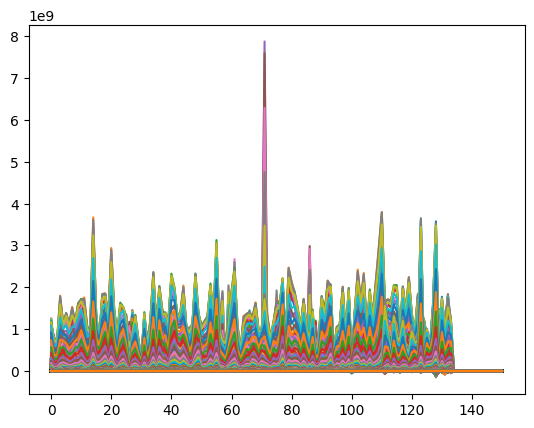

In [4]:
# Extrected and stacked spectra for the 134 pituitary tumour samples

rold = []# initializes an empty list ' rold'
np_ts = len(nd.nmrdat[0][i].spc[0])#Calculate the lenght of the nd.nmrdat[0][i].spc and assigns it to the variable np_ts
ns_pc = len(nd.nmrdat[0])# Calculate the lenght of the nd.nmrdat[0] and assign it to the variable ns_pc
rold = np.array([[]]) # initializes a 2D Numpypy rold with array rold with an empty array 
rold = np.resize(rold, (ns_pc, np_ts))# Resizes the rold array to have the dimension(ns_pc, np_ts)
for i in range (134):# start a loop that iterate  over the range of value from 0 to ns_pc -1
    rold[i] = (nd.nmrdat[0][i].spc[0])# assigns the data from the nd.nmrdat[0][i].spc[0] array to the i-th row of the rold array - it populate the rold array with the spectra data
plt.plot(rold)

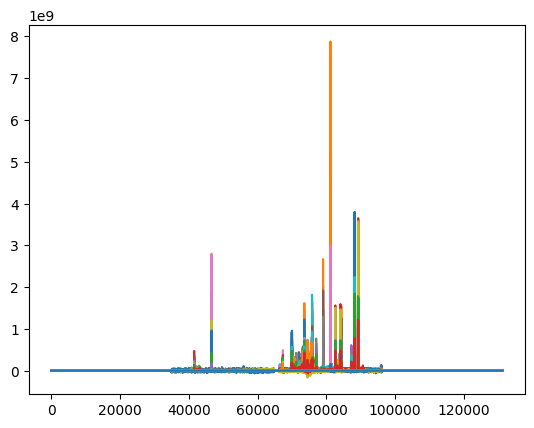

In [6]:
# Stacking of the 134 sample across 131,000 data points
plt.plot(rold.transpose())

[5.61242295e+08 5.45868697e+08 3.95869279e+08 3.57237143e+08
 3.45192127e+08 3.42602443e+08 3.40700352e+08 3.38335006e+08
 2.13775636e+08 1.68960898e+08 1.62480846e+08 1.55035152e+08
 1.49333370e+08 1.49082966e+08 1.47710038e+08 1.45889976e+08
 1.44773550e+08 1.43215076e+08 1.41883121e+08 1.38270160e+08]
[88181 88257 79046 89200 75859 75856 89268 89266 84354 73600 74518 75800
 75547 82602 73186 84093 75807 89196 70019 69943]


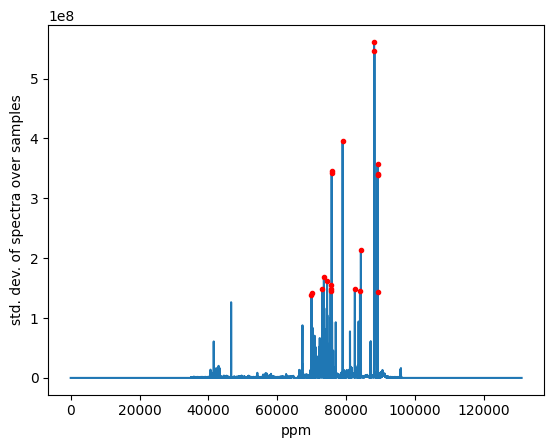

In [60]:
#The implementation of the standard deviation with z-score and missing values imputation.
#It selects 20 columns/ppm(s) with highest standard deviation from the 134 stacked pituitary tumours samples

roly = pd.DataFrame(rol)
zz_scored = ss.zscore(roly, axis=0)
zz_scores = np.array(zz_scored)

z_thresh = 2.575
out_mask = np.abs(zz_scored) > z_thresh
roly[out_mask] = np.nan

imputery = SimpleImputer(strategy ='mean')
roly = imputery.fit_transform(roly)

stdvec7 = np.nanstd(roly, axis=0)
localmaxidx7, _ = ssig.find_peaks(stdvec7)
idxsorted_stdvec7 = np.flipud(np.argsort(stdvec7[localmaxidx7]))

num_maxima_to_display = 20
print(stdvec7[localmaxidx7[idxsorted_stdvec7[:num_maxima_to_display]]])
print(localmaxidx7[idxsorted_stdvec7[:num_maxima_to_display]])

plt.plot(stdvec7) #plot std. dev.
plt.plot(localmaxidx7[idxsorted_stdvec7[0:20]], stdvec7[localmaxidx7[idxsorted_stdvec7[0:20]]], color='red',
     marker='o', markersize=3, linestyle='none') #plot std. dev. local maxima
plt.xlabel("ppm")
plt.ylabel("std. dev. of spectra over samples")
plt.show()


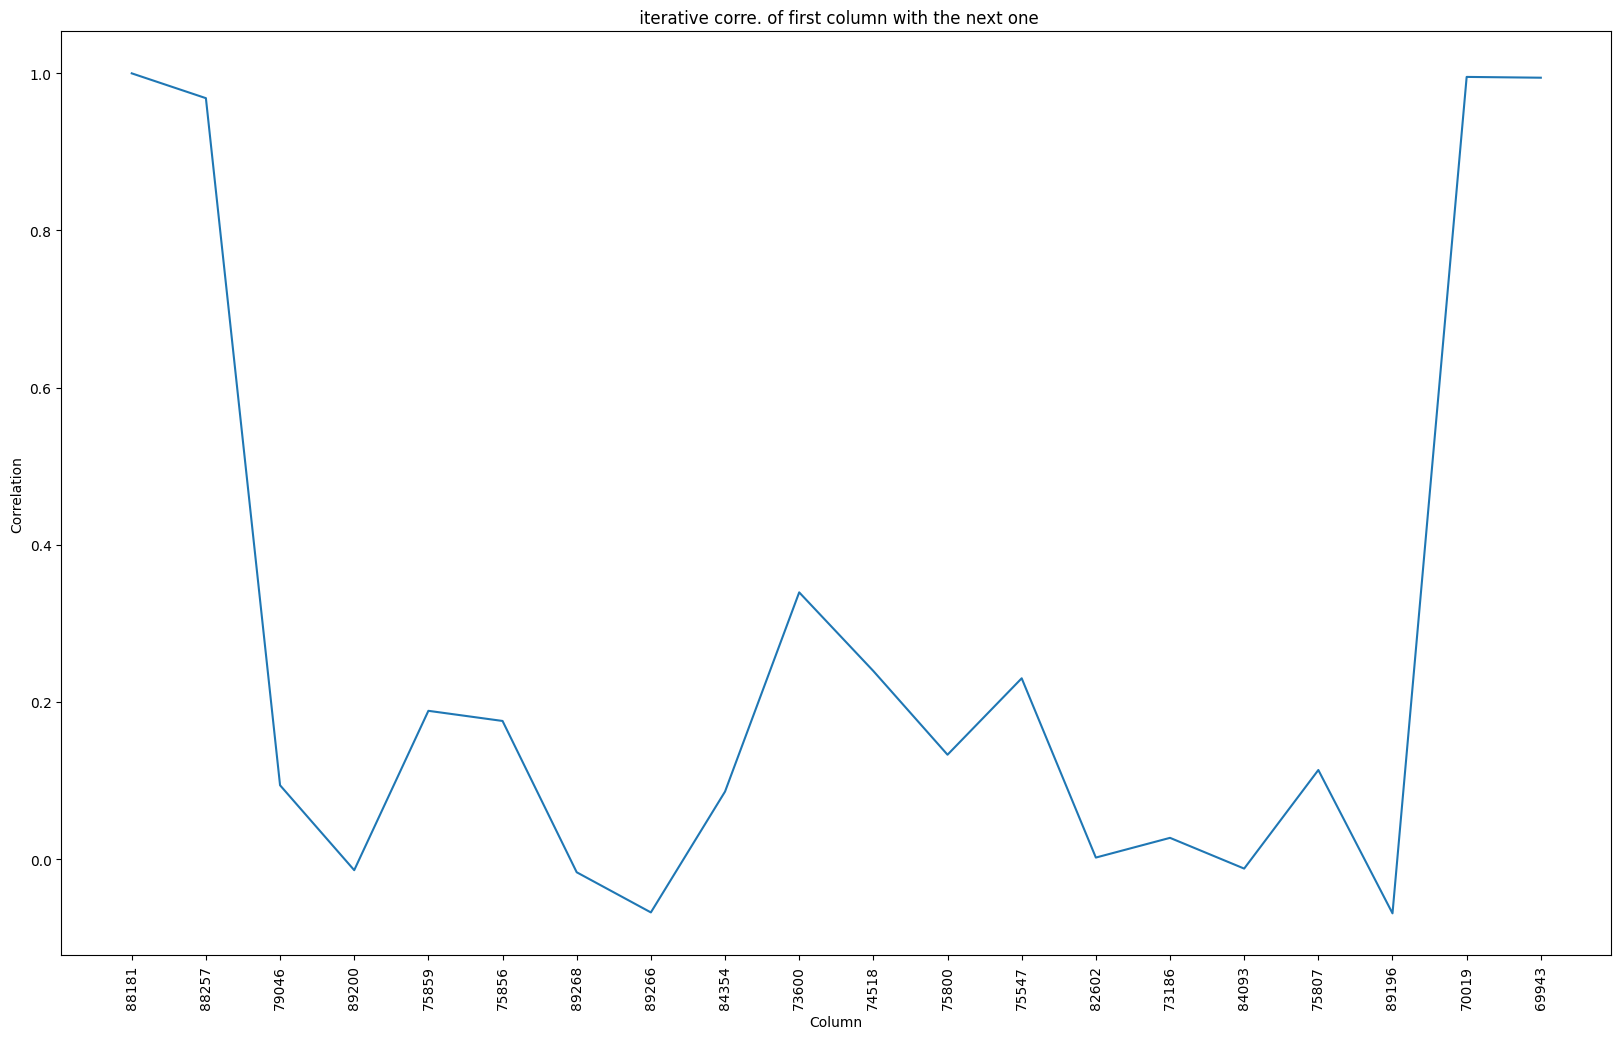

In [61]:
#the iterative correlation values between the highest standard deviation column and the subsequent next Highest 19 local peaks 20 columns
ass_stdvec7 = stdvec7[localmaxidx7[idxsorted_stdvec7[0:20]]]
srt_std7 = localmaxidx7[idxsorted_stdvec7[0:20]]
cortto = []# initialize an empty list to store the correlation values.
for itht in range(0, len(srt_std7)):# Loop over the range of column indices starting from 1 to the last column index.
        ithc3 = srt_std7[0]# get the column index of the first column
        ithc4 = srt_std7[itht]# Get the column index of the column being considered in loop
        clms3t = roly[:, ithc3].reshape(-1, 1)#obtain the data-info from the first column
        clms4t = roly[:, ithc4].reshape(-1, 1)# data-info from the current column
        cor_mats = np.corrcoef(clms3t, clms4t, rowvar=False)#execute the correlation between the columns
        cortto.append(cor_mats[0, 1:])# save the results of the correlation in the empty list cort.    
plt.figure(figsize=(20, 12))   
plt.plot(range(0, len(srt_std7)), cortto)# plot the stored correlation value in cort against the column index 
plt.xlabel('Column')# Give the x-axis a label name column
plt.ylabel('Correlation')# Give the y-axis the label name correlation
plt.title(' iterative corre. of first column with the next one')# label the plot title
plt.xticks(range(len(srt_std7)), srt_std7, rotation=90)
plt.show()# show the plot

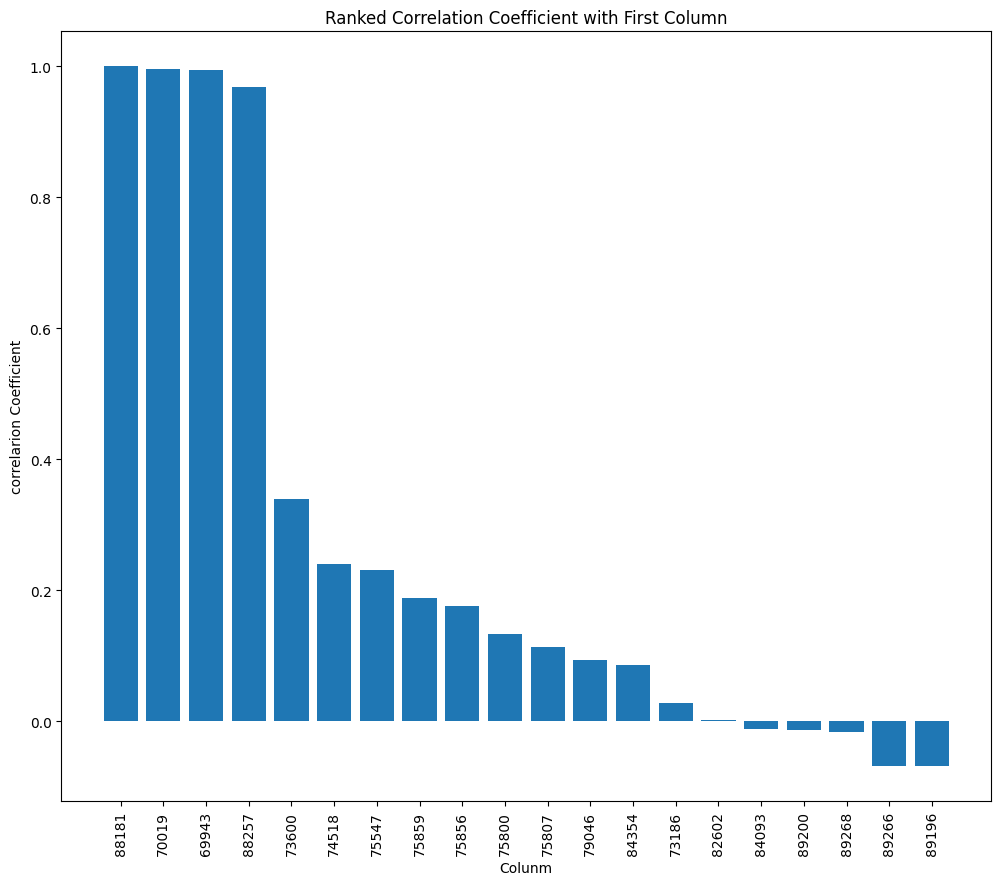

([<matplotlib.axis.YTick at 0x1be15020c10>,
 [Text(0, 0, '88181'),
  Text(0, 1, '88257'),
  Text(0, 2, '79046'),
  Text(0, 3, '89200'),
  Text(0, 4, '75859'),
  Text(0, 5, '75856'),
  Text(0, 6, '89268'),
  Text(0, 7, '89266'),
  Text(0, 8, '84354'),
  Text(0, 9, '73600'),
  Text(0, 10, '74518'),
  Text(0, 11, '75800'),
  Text(0, 12, '75547'),
  Text(0, 13, '82602'),
  Text(0, 14, '73186'),
  Text(0, 15, '84093'),
  Text(0, 16, '75807'),
  Text(0, 17, '89196'),
  Text(0, 18, '70019'),
  Text(0, 19, '69943')])

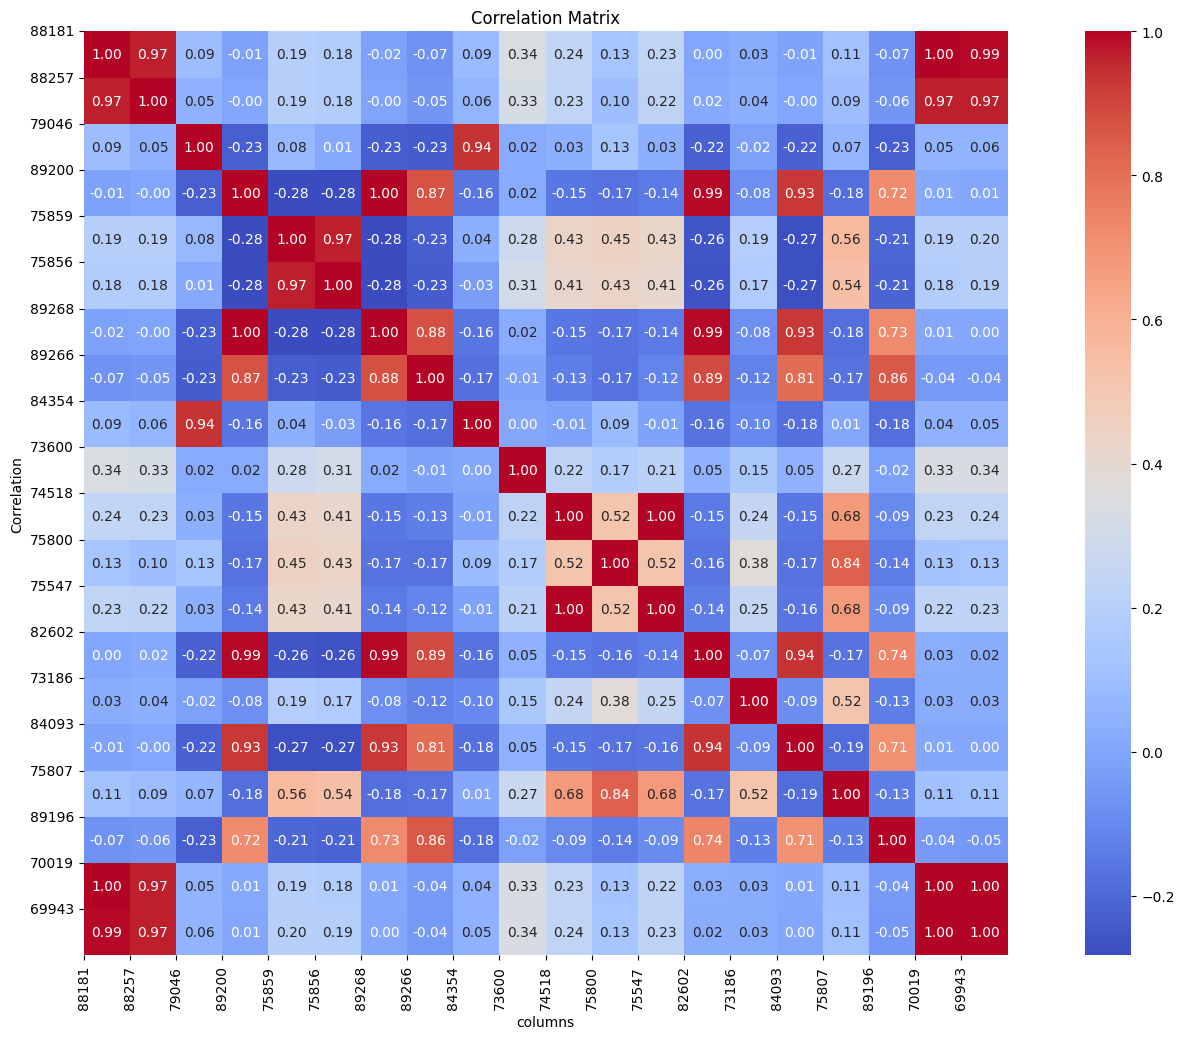

In [85]:
# Ranked Correlation Matrix Between the Highest and the between the highest standard deviation column and the subsequent next Highest 19 local peaks 20 columns

corttz =[]
for ith1 in range(0, len(srt_std7)):# Loop over the range of column indices starting from
        ithc3 = srt_std7[0]# get the column index of the first column
        ithc4 = srt_std7[ith1]# Get the column index of the column being considered in loop
        clms3s = roly[:, ithc3].reshape(-1, 1)#obtain the data-info from the first column
        clms4s = roly[:, ithc4].reshape(-1, 1)# data-info from the current column
        clms3_zz = zscore(clms3s)
        clms4_zz = zscore(clms4s)
        cor_maats = np.corrcoef(clms3_zz, clms4_zz, rowvar=False)
        cor_mats = np.corrcoef(clms3s, clms4s, rowvar=False)#execute the correlation between the columns
        corttz.append(cor_mats[0, 1])# save the results of the correlation in the empty list cort
        
sorted_inn = np.argsort(corttz)[::-1]
srt_std7_srn = np.array(corttz)[sorted_inn]

plt.figure(figsize=(12, 10))
plt.bar(range(1, len(srt_std7) + 1), srt_std7_srn)
plt.xlabel('Colunm')
plt.ylabel('correlarion Coefficient')
plt.title('Ranked Correlation Coefficient with First Column')
plt.xticks(range(1, len(srt_std7) +1), srt_std7[sorted_inn], rotation=90)
plt.show()

fig, ad = plt.subplots(figsize=(20, 12))#give the plot window specification
cor_mat1s = np.corrcoef(roly[:, srt_std7], rowvar=False)#execute the correlation coefficient between the first and the subsequent columns
sbn.heatmap(cor_mat1s, cmap='coolwarm', annot=True, fmt='.2f', square=True)#create heatmap matrix plot
    
plt.title('Correlation Matrix')# state the title of the plot
plt.xlabel('columns')#give the x-axis a name column 
plt.ylabel('Correlation')#give the y-axix a name correlation
plt.xticks(range(len(srt_std7)), srt_std7, rotation=90)#Display the labey from the data-srt_std for x-axis
plt.yticks(range(len(srt_std7)), srt_std7, rotation=0)#Display the labey from the data-srt_std for y-axis
    


C:\Users\bosmi\anaconda3\envs\metabolabpy\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\bosmi\anaconda3\envs\metabolabpy\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\bosmi\anaconda3\envs\metabolabpy\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\bosmi\anaconda3\envs\metabolabpy\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  war

Optimal Number of Clusters (k): 2
Maximum Silhouette Score: 0.9043
Percent for ecah Tumor Cluster 1: Tumour_Class
0    100.000000
1    100.000000
2     92.307692
3    100.000000
4     80.000000
5     80.952381
6     66.666667
7     78.571429
Name: count, dtype: float64
Percent for each Tumour Cluster 2: Tumour_Class
0          NaN
1          NaN
2     7.692308
3          NaN
4    20.000000
5    19.047619
6    33.333333
7    21.428571
Name: count, dtype: float64
Cluster 1 Class: ['2', '3', '3', '5', '2', '0', '2', '1', '2', '1', '1', '4', '2', '2', '7', '2', '2', '5', '7', '5', '1', '2', '2', '5', '2', '2', '2', '6', '5', '6', '4', '2', '3', '2', '7', '2', '7', '2', '2', '2', '7', '1', '7', '5', '1', '5', '2', '3', '7', '2', '2', '2', '7', '1', '0', '1', '2', '3', '2', '1', '5', '7', '2', '1', '2', '2', '5', '2', '1', '2', '2', '2', '2', '2', '1', '5', '2', '1', '3', '5', '2', '5', '2', '1', '1', '5', '4', '2', '2', '3', '1', '6', '2', '2', '6', '0', '3', '1', '2', '2', '0', '3', '4', '

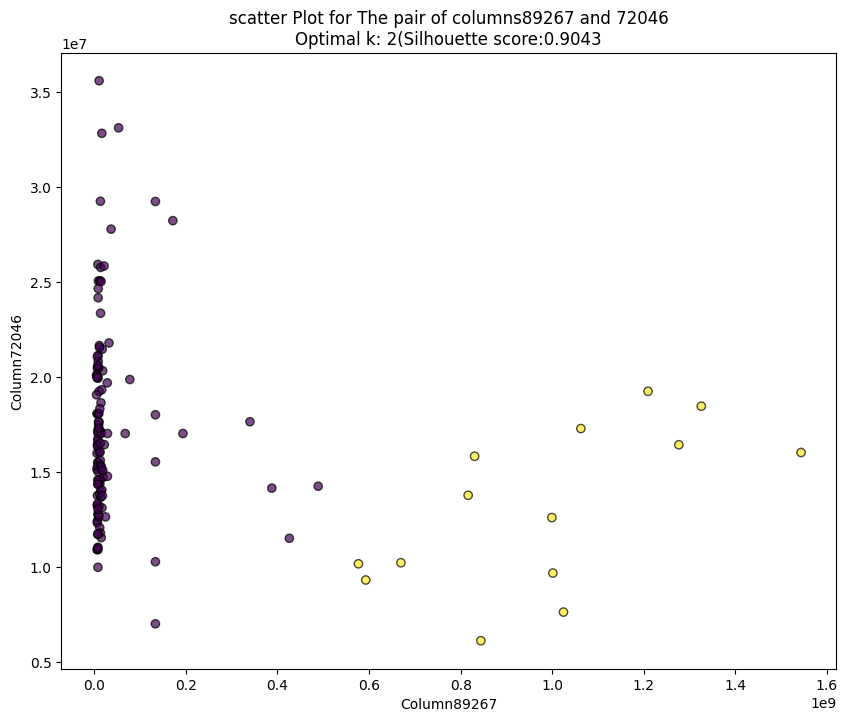

Cluster 1 Tumour counts:
Tumour_Class
2    48
1    21
5    17
3    11
7    11
0     4
4     4
6     4
Name: count, dtype: int64

Cluster 2 Tumour Counts:
Tumour_Class
5    4
2    4
7    3
6    2
4    1
Name: count, dtype: int64


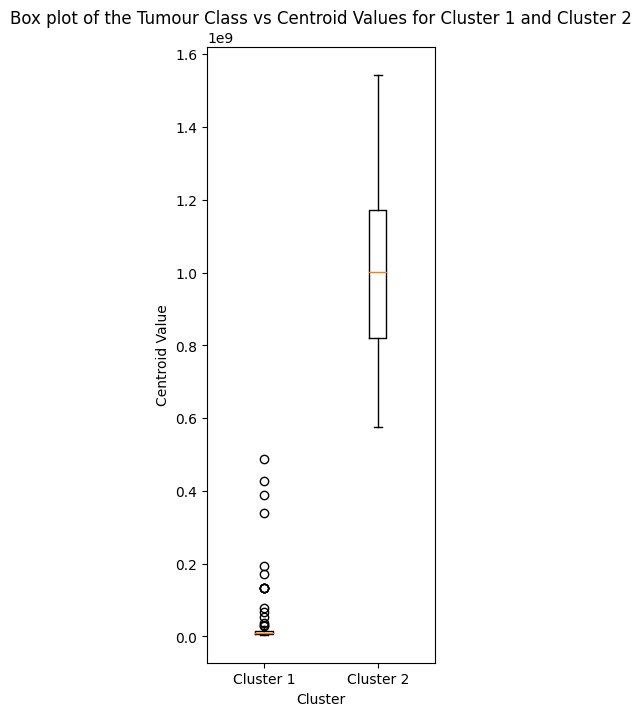

In [71]:
# The pair peaks with maximum silhouette score cluster estimation

def optimized_log(x, c=1):
   return np.log(x + c)

def meta_data(nd, property =''):
    if len(property) == 0:
        return []
    
    n_spc = len(nd.nmrdat[nd.s])
    data_vector = []
    for k in range(134):
        title = nd.nmrdat[nd.s][k].title
        try:
            try:
                idx1 = title.index(property)
            except:
                idx1 = title.index(property.replace(' ', '_'))
                
            sub_str = title[idx1:]
            idx2 = sub_str.index(':')
            idx3 = sub_str.index('\n')
            data_vector.append(sub_str[idx2 + 1:idx3].strip())
        except:
            print(f'property not found! (exp: {k + 1})')
            data_vector.append('not found')
        
        
    return data_vector

tumour_type = 'tumour'
tumour_class = meta_data(nd, 'tumour')
tumour_class = [ 0 if value == 'not found' else value for value in tumour_class]

e = pd.DataFrame({'Tumour_Class':tumour_class})
pd.set_option('display.max_row', None)
pd.set_option('display.max_columns', None)

# the pair peak with maximum silhouette score
ihc1 = 89267
ihc2 = 72046

coc1 = roly[:, ihc1].reshape(-1, 1)
coc2 = roly[:, ihc2].reshape(-1, 1)
datao = np.hstack((coc1, coc2))

silhouette_src = []
for k in range(2, 16):
    kmop = KMeans(n_clusters=k)
    kmop.fit(datao)
    labb = kmop.labels_
    
    sil_op = silhouette_score(datao, labb)
    silhouette_src.append(sil_op)
    
op_kk = np.argmax(silhouette_src) +2

print(f'Optimal Number of Clusters (k): {op_kk}')
print(f'Maximum Silhouette Score: {max(silhouette_src):.4f}')

opt_kmop = KMeans(n_clusters = op_kk)
opt_kmop.fit(datao)
opt_labb = opt_kmop.labels_

cluster_ind1 = np.where(opt_labb ==0)[0]
cluster_ind2 = np.where(opt_labb ==1)[0]

cluster_cl1 = e['Tumour_Class'].iloc[cluster_ind1]
cluster_cl2 = e['Tumour_Class'].iloc[cluster_ind2]

# calculate and display pecentage of tumour cluss belonging to cluter 1 and cluster 2
tot_cta = e['Tumour_Class'].value_counts()
clust1a_per = cluster_cl1.value_counts()
clust2a_per = cluster_cl2.value_counts()

clust1a_percent = (clust1a_per/tot_cta)* 100
clust2a_percent = (clust2a_per/tot_cta)* 100

cluster_val1 = datao[cluster_ind1]
cluster_val2 = datao[cluster_ind2]

print('Percent for ecah Tumor Cluster 1:', clust1a_percent)
print('Percent for each Tumour Cluster 2:', clust2a_percent)

print('Cluster 1 Class:', cluster_cl1.tolist())
print('Cluster 1 Values:', cluster_val1.tolist())

print('Cluster 2 Class:', cluster_cl2.tolist())
print('Cluster 2 Values:', cluster_val2.tolist())


plt.figure(figsize=(10, 8))
plt.scatter(coc1, coc2, c=opt_labb, cmap ='viridis', edgecolor ='k', alpha=0.7)
plt.xlabel(f'Column{ihc1}')
plt.ylabel(f'Column{ihc2}')
plt.title(f'scatter Plot for The pair of columns{ihc1} and {ihc2}\nOptimal k: {op_kk}(Silhouette score:{max(silhouette_src):.4f}')
plt.show()

clust_class1 =  e['Tumour_Class'].iloc[cluster_ind1]
clust_class2 = e['Tumour_Class'].iloc[cluster_ind2]


clust1_tumour_c = clust_class1.value_counts()
clust2_tumour_c = clust_class2.value_counts()


print('Cluster 1 Tumour counts:')
print(clust1_tumour_c)


print('\nCluster 2 Tumour Counts:')
print(clust2_tumour_c)

centd1 = np.mean(cluster_val1, axis=0)
centd2 = np.mean(cluster_val2, axis=0)

centr_df = pd.DataFrame({'Cluster':['Cluster 1', 'Cluster 2'],
                        'Centroid': [centd1, centd2]})


df_clust_cls1 = pd.DataFrame({'Cluster 1': clust_class1})
df_clust_cls2 = pd.DataFrame({'Cluster 2': clust_class2})

plt.figure(figsize=(10, 8))

plt.subplot(1, 3, 1)


plt.boxplot([cluster_val1[:, 0], cluster_val2[:, 0]], labels=['Cluster 1', 'Cluster 2'])

plt.xlabel('Cluster')
plt.ylabel('Centroid Value')
plt.title('Box plot of the Tumour Class vs Centroid Values for Cluster 1 and Cluster 2')

plt.show() 

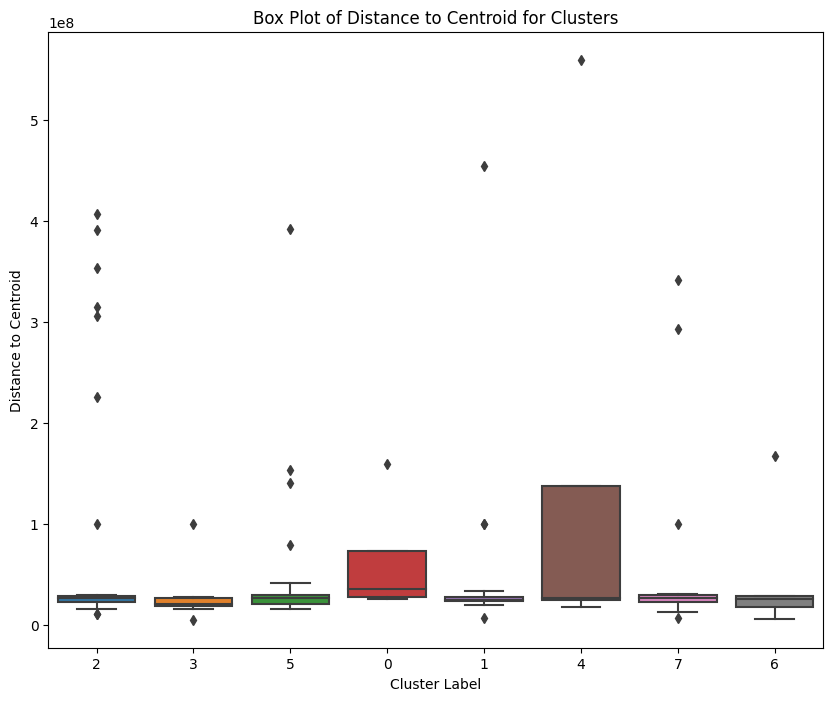

In [66]:
# Calculate distances to centroids for Cluster 1
distan_clus1 = np.sqrt(np.sum((cluster_val1 - centd1) ** 2, axis=1))

# Calculate distances to centroids for Cluster 2
distan_clus2 = np.sqrt(np.sum((cluster_val2 - centd2) ** 2, axis=1))

# Create DataFrames for each cluster with distances and cluster labels
df_clust_cls1 = pd.DataFrame({'Cluster Label': cluster_cl1, 'Distance to Centroid': distan_clus1})
df_clust_cls2 = pd.DataFrame({'Cluster Label': cluster_cl2, 'Distance to Centroid': distan_clus2})

# Plot the box plot
plt.figure(figsize=(10, 8))
sbn.boxplot(data=pd.concat([df_clust_cls1, df_clust_cls2]), x='Cluster Label', y='Distance to Centroid')
plt.xlabel('Cluster Label')
plt.ylabel('Distance to Centroid')
plt.title('Box Plot of Distance to Centroid for Clusters')
plt.show()

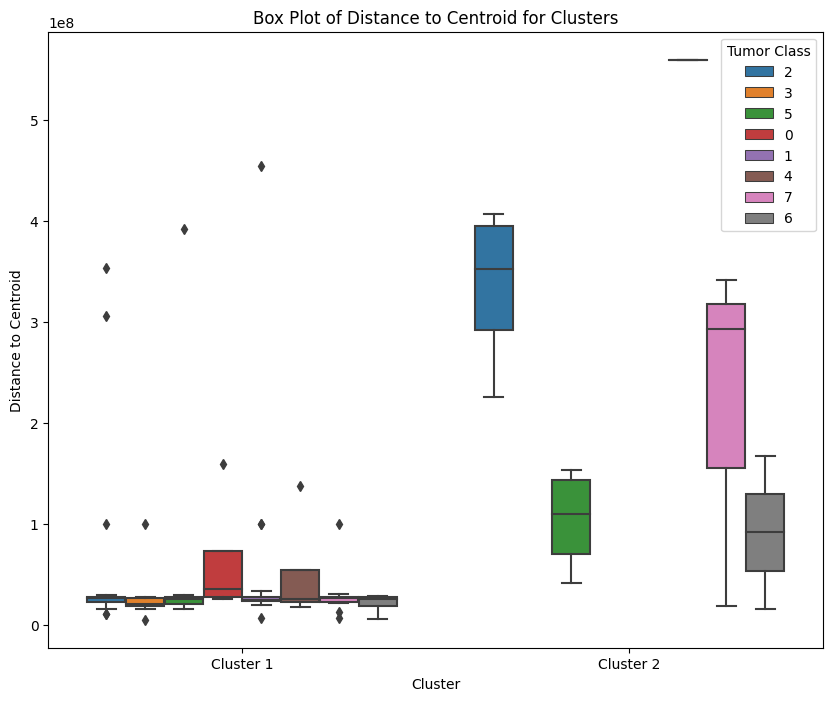

In [76]:
distances_cluster1 = [euclidean(point, centd1) for point in cluster_val1]
distances_cluster2 = [euclidean(point, centd2) for point in cluster_val2]

# Create DataFrames for each cluster with distances and cluster labels
df_clust_cls1 = pd.DataFrame({'Cluster': 'Cluster 1', 'Tumor Class': cluster_cl1, 'Distance to Centroid': distances_cluster1})
df_clust_cls2 = pd.DataFrame({'Cluster': 'Cluster 2', 'Tumor Class': cluster_cl2, 'Distance to Centroid': distances_cluster2})

# Concatenate the DataFrames
df_combined = pd.concat([df_clust_cls1, df_clust_cls2])

# Plot the box plot
plt.figure(figsize=(10, 8))
sbn.boxplot(data=df_combined, x='Cluster', y='Distance to Centroid', hue='Tumor Class')
plt.xlabel('Cluster')
plt.ylabel('Distance to Centroid')
plt.title('Box Plot of Distance to Centroid for Clusters')
plt.show()

In [82]:
# Calculate distances for each data point to centroids
distances = []
for point in datao:
    distance1 = np.linalg.norm(point - centd1)
    distance2 = np.linalg.norm(point - centd2)
    distances.append((distance1, distance2))

# Create a DataFrame for distances
df_distances = pd.DataFrame(distances, columns=['Distance to Centroid 1', 'Distance to Centroid 2'])

# Add Tumor Class column from the original DataFrame
df_distances['Tumor Class'] = e['Tumour_Class']

# Calculate p-values for each tumor class
p_values = []
for tumor_class in np.unique(df_distances['Tumor Class']):
    distances_class = df_distances.loc[df_distances['Tumor Class'] == tumor_class]
    _, p_value = ranksums(distances_class['Distance to Centroid 1'], distances_class['Distance to Centroid 2'])
    p_values.append((tumor_class, p_value))

# Display the p-values
for tumor_class, p_value in p_values:
    print(f'Tumor Class: {tumor_class}, p-value: {p_value:.4f}')

Tumor Class: 0, p-value: 0.0209
Tumor Class: 1, p-value: 0.0000
Tumor Class: 2, p-value: 0.0000
Tumor Class: 3, p-value: 0.0001
Tumor Class: 4, p-value: 0.1172
Tumor Class: 5, p-value: 0.0000
Tumor Class: 6, p-value: 0.1093
Tumor Class: 7, p-value: 0.0115


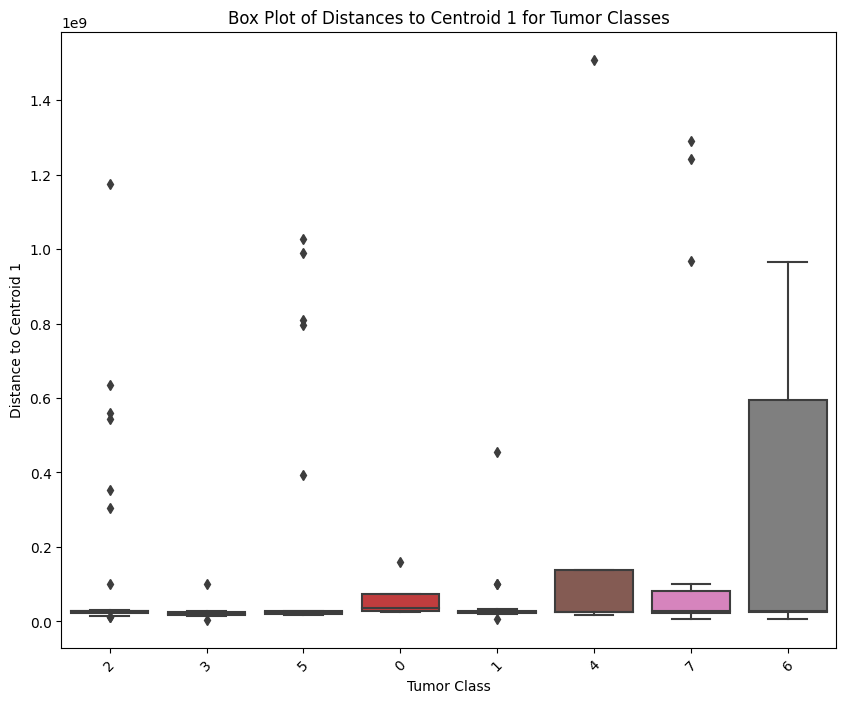

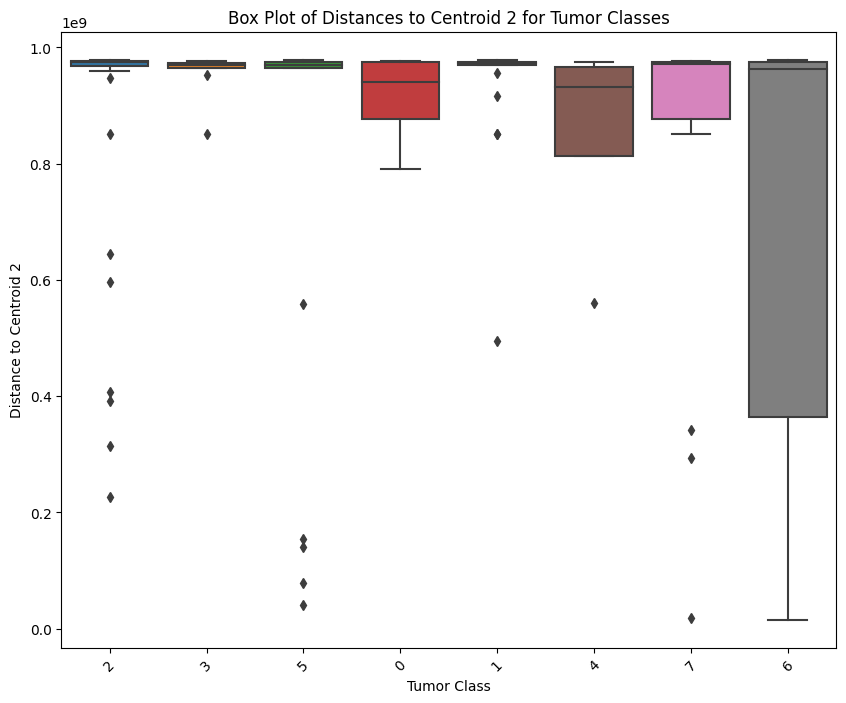

In [83]:
# Calculating the distances from the centroid 1
plt.figure(figsize=(10, 8))
sbn.boxplot(data=df_distances, x='Tumor Class', y='Distance to Centroid 1')
plt.xlabel('Tumor Class')
plt.ylabel('Distance to Centroid 1')
plt.title('Box Plot of Distances to Centroid 1 for Tumor Classes')
plt.xticks(rotation=45)
plt.show()

#Calculating the distances from centroid 2
plt.figure(figsize=(10, 8))
sbn.boxplot(data=df_distances, x='Tumor Class', y='Distance to Centroid 2')
plt.xlabel('Tumor Class')
plt.ylabel('Distance to Centroid 2')
plt.title('Box Plot of Distances to Centroid 2 for Tumor Classes')
plt.xticks(rotation=45)
plt.show()

In [84]:
#Clculation of the adjusted p Value
p_values = [
    (0, 0.0209),    # Replace nan with 1.0 for calculation
    (1, 0.0001),    # Replace nan with 1.0 for calculation
    (2, 0.0001),
    (3, 0.0001),    # Replace nan with 1.0 for calculation
    (4, 0.1172),
    (5, 0.0001),
    (6, 0.1093),
    (7, 0.0115)
]
# Number of tests
num_tests = len(p_values)

# Bonferroni corrected significance level
alpha_corrected = 0.05

# Calculate adjusted p-values based on Bonferroni correction
adjusted_p_values = [(tumor_class, min(1, p_value * num_tests)) for tumor_class, p_value in p_values]

# Compare adjusted p-values to corrected significance level and display results
for tumor_class, adjusted_p_value in adjusted_p_values:
    if adjusted_p_value < alpha_corrected:
        print(f"Tumor Class {tumor_class}: Significant (adjusted p-value = {adjusted_p_value:.4f})")
    else:
        print(f"Tumor Class {tumor_class}: Not significant (adjusted p-value = {adjusted_p_value:.4f})")

Tumor Class 0: Not significant (adjusted p-value = 0.1672)
Tumor Class 1: Significant (adjusted p-value = 0.0008)
Tumor Class 2: Significant (adjusted p-value = 0.0008)
Tumor Class 3: Significant (adjusted p-value = 0.0008)
Tumor Class 4: Not significant (adjusted p-value = 0.9376)
Tumor Class 5: Significant (adjusted p-value = 0.0008)
Tumor Class 6: Not significant (adjusted p-value = 0.8744)
Tumor Class 7: Not significant (adjusted p-value = 0.0920)


In [ ]:
#This Indicates that tumour classes 1, 2, 3, and 5 corresponding to Acromegaly, Gonadotroph, Cushin's and Null Cell have dinstint characteristics metabolic profile
